In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

This project is using the data from Kaggle. The 'train.csv' contains four-year-sales of 50 items of 10 stores from 2014 to the end of 2017.
In this simple demand forcasting example, I am using the last three month data as a test set. The rest data will be used as training set.

In [59]:
input_dir = './data/'

df = pd.read_csv(os.path.join(input_dir, 'train.csv'), index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3)
memory usage: 27.9 MB


In [4]:
df.head(5)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


# Part One: EDA

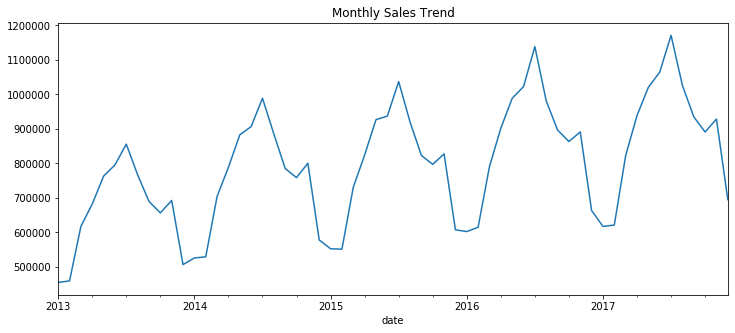

In [6]:
temp = df['sales'].resample('MS').sum()
temp.plot(title='Monthly Sales Trend', figsize=(12,5))
plt.show()

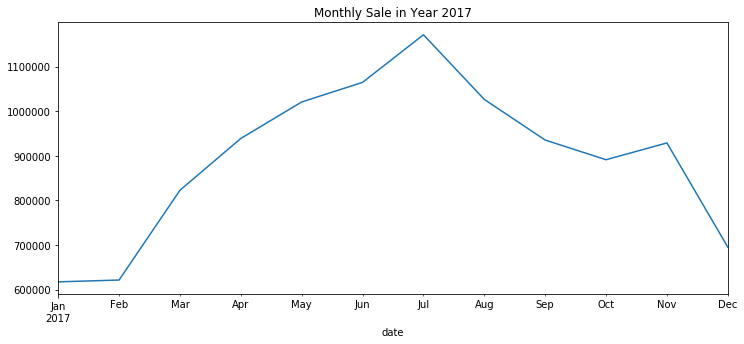

In [7]:
temp['2017':].plot(title='Monthly Sale in Year 2017', figsize=(12,5))
plt.show()

Insights:
* yearly sales is increasing steadily from 2013 to 2017
* monthly sales shows a seasonality pattern - summer is the highest (especially for July) and winter is the lowest
* a small spike in November

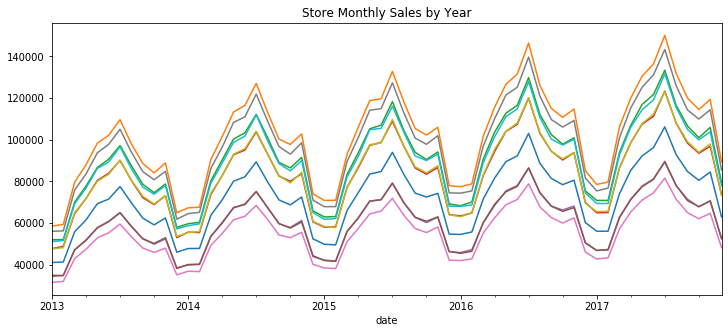

In [8]:
# store difference
temp = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()
temp = temp.resample('MS').sum()
temp.plot(title = 'Store Monthly Sales by Year', figsize = (12,5), legend = None)
plt.show()

Insights:
* stores all share similar patters from the total shown before

In [10]:
# items difference
print('There are {} kinds of items.'.format(len(df.item.unique())))

There are 50 kinds of items.


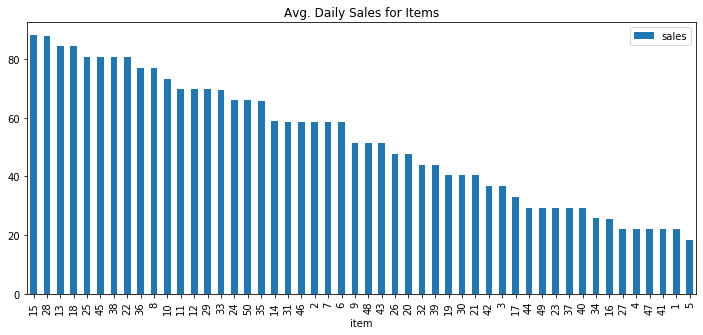

In [12]:
temp = pd.DataFrame({'sales': df.groupby(['item'])['sales'].mean()})
temp.sort_values('sales', ascending=False).plot(kind = 'bar', title = 'Avg. Daily Sales for Items', figsize = (12,5))
plt.show()

Insights:
* Different item has very different daily sales. The largest one - Item 15 has about four times sales volumes than that of Item 5
* Groups of item has similar sales volumes in total, it maybe have similar sale pattern over time. This feature can be used for clustering/dimension reduction in more complicated cases

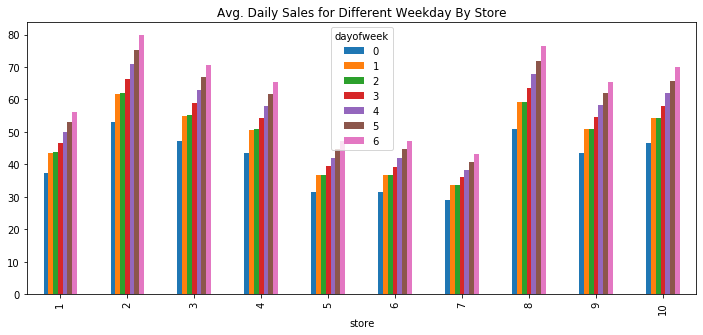

In [36]:
# Weekly Pattern
temp = df.copy(deep=True)
temp['dayofweek'] = temp.index.dayofweek
temp = df.groupby(['store','dayofweek'])['sales'].mean()
temp.unstack().plot(kind = 'bar', title = 'Avg. Daily Sales for Different Weekday By Store', figsize = (12,5))
plt.show()

Insights:
* The daily sales over a week has a clear pattern - increase steadily from Monday to Sunday

# Part Two: Trend

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

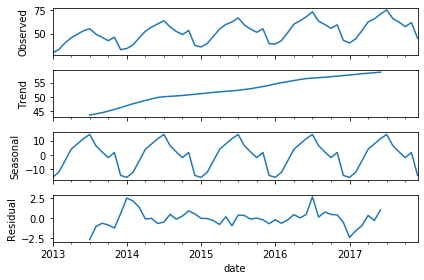

In [16]:
# Monthly Trend
m_decomposition = seasonal_decompose(df['sales'].resample('MS').mean(), model='additive')
m_decomposition.plot()
plt.show()

From the above avg. daily sales by week graph, we can see the sales clearly has seasonality. The trend is almost a straight line that has a steady increasing rate.

# Part Three: ARIMA Forecating For Total Sales

In [17]:
# Use Seasonal ARIMA for forecast the total sales of last three month (2017 Oct to 2017 December)
p = range(0,2)
d = range(0,2)
q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [21]:
# monthly total sales
y = df['sales'].resample('MS').mean()

# split train and test
train = y.loc['2013-01-01':'2017-9-01']
test = y.loc['2017-10-01':]

min_aic = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if min_aic is None or min_aic > results.aic:
                min_aic = results.aic
                min_pdq = param

        except:            
            continue
print('the minimum AIC is {} with param {}'.format(min_aic, min_pdq))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:606.8021368145066
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:482.94846035591354
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:257.62530218480686
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1009.7693980350671
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:202.57975341776665
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:183.6821712768643
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:149.00220215724232
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1108.9229375778505
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:536.1759771142923
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:442.56518255474253
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:204.86301937601183
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1273.8970108758924
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:169.48539111934215
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:184.5015305823948
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:126.47195530016859
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1063.6372584287926
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:366.91616485150917
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:261.16027423644

In [19]:
min_seasonal_order = (min_pdq[0], min_pdq[1], min_pdq[2], 12)

In [41]:
ts_mod = sm.tsa.statespace.SARIMAX(train,order=min_pdq,
                                seasonal_order=min_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
ts_result = ts_mod.fit()
print(ts_result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0808         -0        inf      0.000      -0.081      -0.081
ma.S.L12    1.006e+14         -0       -inf      0.000    1.01e+14    1.01e+14
sigma2      3.466e-09   1.34e-09      2.586      0.010     8.4e-10    6.09e-09


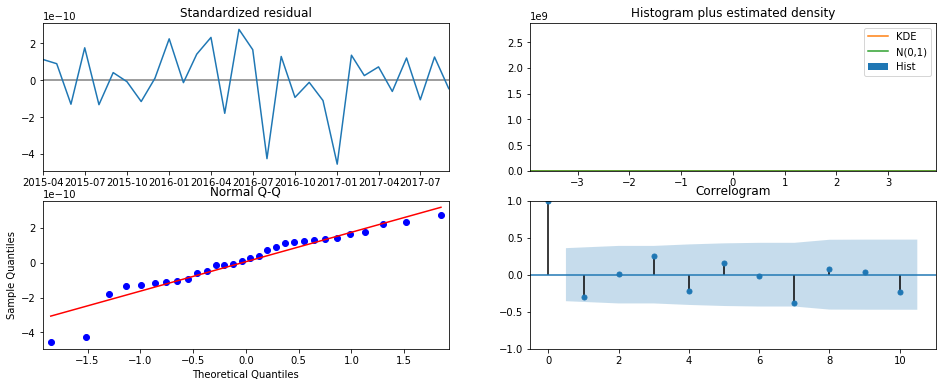

In [42]:
ts_result.plot_diagnostics(figsize=(16, 6))
plt.show()

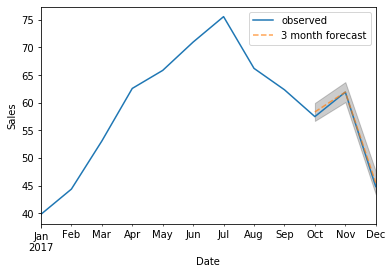

In [32]:
#Compare results on the last three months
pred = results.get_forecast(steps=3)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='3 month forecast', alpha=.7, linestyle = '--')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

From the above graph, we can see that ARIMA has a very good predict accuracy on the total sales in this case. 

Next, I will use light GBM method to predict daily sales of each item in each store. It is very handy in dealing with categorical features like store and item.

# Part Four: Feature Engineering for Light GBM

In [60]:
def add_features(df):
    print('the original data has {} columns, they are {}'.format(df.shape[1], df.columns))
    print('adding features...')
    df_copy = df.copy(deep=True)
    
    # add sales of last year
    df['datelastyear'] = df.index - pd.to_timedelta(365, unit='D')

    df = pd.merge(df, df_copy, left_on = ['datelastyear', 'store','item'], 
                  right_on = ['date','store','item'], suffixes=('', 'lastyear'))
    df['date'] = df['datelastyear'] + pd.to_timedelta(365, unit='D')
    df = df.set_index('date')
    df = df.drop('datelastyear', axis = 1)
    # additional features
    df['dayofweek'] = df.index.dayofweek
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    print('Now the data has {} columns, they are {}'.format(df.shape[1], df.columns))
    
    # Split data into Train and Test to calculate Model accuracy
    # Use last 3 month data - 2017 Oct, Nov and Dec as Test
    train = df.loc[df.index< pd.to_datetime('October 1, 2017')]
    test = df.loc[df.index >= pd.to_datetime('October 1, 2017')]

    Xcol = [col for col in df.columns if col != 'sales']
    ycol = 'sales'
    X_train = train[Xcol]
    y_train = train[ycol]
    X_test = test[Xcol]
    y_test = test[ycol]
    return X_train, y_train, X_test, y_test

In [61]:
X_train, y_train, X_test, y_test = add_features(df)

the original data has 3 columns, they are Index(['store', 'item', 'sales'], dtype='object')
adding features...
Now the data has 8 columns, they are Index(['store', 'item', 'sales', 'saleslastyear', 'dayofweek', 'year', 'month',
       'dayofyear'],
      dtype='object')


In [62]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(684500, 7)
(684500,)
(46000, 7)
(46000,)


# Part Five: Light GBM Forecating

In [63]:
import lightgbm as lgb

In [87]:
def lgbmodel(x_train,y_train,x_test,y_test):
    params = {
        'nthread': 10,
        'max_depth': 5,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape', # this is abs(a-e)/max(1,a)
        'learning_rate': 0.3,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 1,
        }
    
    lgb_train = lgb.Dataset(x_train,y_train,categorical_feature=['store','item','month','dayofweek'])
    lgb_valid = lgb.Dataset(x_test,y_test,categorical_feature=['store','item','month','dayofweek'])
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],
                      early_stopping_rounds=50, verbose_eval=50)
    return model

In [88]:
model = lgbmodel(X_train,y_train,X_test,y_test)

Training until validation scores don't improve for 50 rounds
[50]	training's mape: 0.133554	valid_1's mape: 0.132589
[100]	training's mape: 0.128658	valid_1's mape: 0.128703
[150]	training's mape: 0.127332	valid_1's mape: 0.127194
[200]	training's mape: 0.126775	valid_1's mape: 0.126986
[250]	training's mape: 0.126396	valid_1's mape: 0.126909
Early stopping, best iteration is:
[239]	training's mape: 0.126471	valid_1's mape: 0.126886


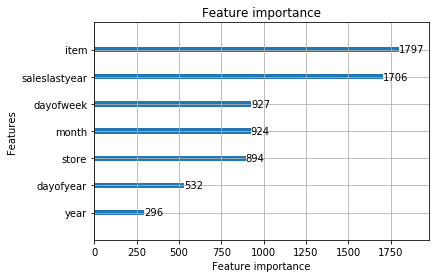

In [89]:
# feature importance
lgb.plot_importance(model)
plt.show()

In [90]:
# predict last 3 month item daily sales by sotre
pred_sales = model.predict(X_test)

In [94]:
test = pd.concat([X_test, y_test], axis = 1)
test['predicted_sales'] = pred_sales

In [95]:
test.head(5)

,store,item,saleslastyear,dayofweek,year,month,dayofyear,sales,predicted_sales
date,,,,,,,,,
2017-10-01,1,1,25,6,2017,10,274,21,24.761201
2017-10-02,1,1,26,0,2017,10,275,12,16.184496
2017-10-03,1,1,20,1,2017,10,276,18,18.786528
2017-10-04,1,1,28,2,2017,10,277,15,20.496842
2017-10-05,1,1,17,3,2017,10,278,20,20.433994


In [114]:
# monthly total by store
temp = pd.DataFrame(test.groupby(['date','store']).sum()[['sales', 'predicted_sales']]).unstack()
temp = temp.resample('MS').sum()

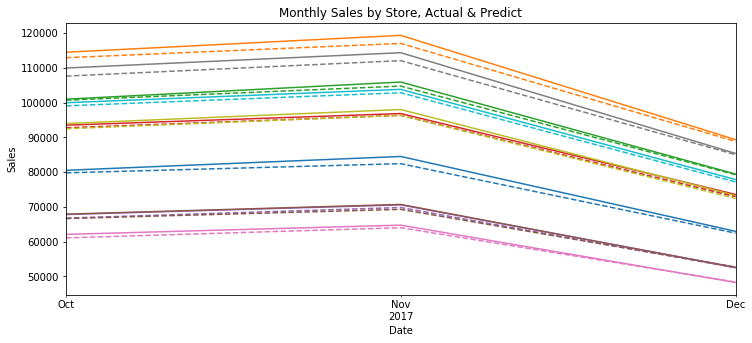

In [116]:
ax = temp['sales'].plot(label='actual',legend = None, title = 'Monthly Sales by Store, Actual & Predict')
temp['predicted_sales'].plot(ax = ax, label='predict', linestyle='--', figsize=(12, 5),legend = None)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

In [118]:
# Item 5, 6, 15 Weekly Sales in 6 months 2017 Oct to 2018 March
temp = test.loc[test['item'].isin((5,6,15))]
temp = pd.DataFrame(temp.groupby(['date','item']).sum()[['sales','predicted_sales']]).unstack()
temp = temp.resample('7D').sum()

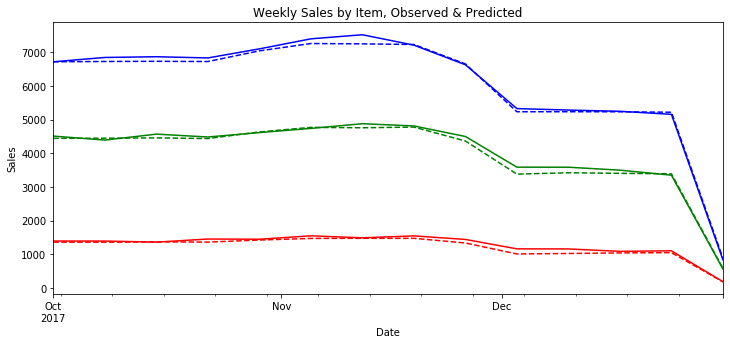

In [127]:
ax = temp['sales'].plot(label='actual',legend = None, 
                        title = 'Weekly Sales by Item, Observed & Predicted', color = ('r','g','b'))
temp['predicted_sales'].plot(ax = ax, label='predict', linestyle='--', 
                             figsize=(12, 5), legend = None, color = ('r','g','b'))
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

Insights:
* The light GBM is efficient when dealing with categorical features. It is 8x faster than one hot encoder.
* This is a very simple case as we only know date, store and item. In practics, the data could have more features like product cycle, price, inventory and external factors like weather, economics, etc. Light GBM is more scalable comparing to traditional time series analysis.
* In this case the predicted sales are smaller than the actual sales number in most data points. The reason why this happen could be that the data are more related to data of closer months. For example, the sales on 2017/10/01 is more related to data points in 2017 September than those of 2014 September. Therefore, it may make more sense if we apply a weight on the datapoints when fitting into the model.